# TRAFFIC SIGN RECOGNITION GERMAN DATASET

## INDICE
 0. CARGA DE DATOS
 1. MODELO
 2. VISUALIZACIÓN DE LOS PESOS  
     2.1 ANALSIS DE SENSIBILIDAD  
 3. CONFUSSION MATRIX
 4. PORCENTAJE DE ACIERTOS

## 1. CARGA DE DATOS

In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import csv
import math

# Allow image embeding in notebook
%matplotlib inline

In [2]:
def load_data(data_dir):
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]

    labels = []
    images = []
    #print(directories)
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    
    images32 = [skimage.transform.resize(image, (32, 32))for image in images]
    
    labels2=np.array(labels)
    images2=np.array(images32)
    
    #print(label_dir)
    return images2, labels2

In [3]:
train_data_dir = ".\\data\\Training"            
X_train_orig, Y_train_orig = load_data(train_data_dir)
#print(Y_train_orig)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [4]:
def load_test_data (data_dir):
    labels  = []
    labels2 =[]
    images = []
    
    with open('GT-final_test.csv', 'r') as f:
      reader = csv.reader(f)
      labels = list(reader)
    #print(labels)
    for d in range(1,len(labels)):
        labels2.append(int(labels[d][0]))
    #print(len(labels))
    
    file_names = [os.path.join(data_dir, f) 
                  for f in os.listdir(data_dir) if f.endswith(".ppm")]
    for f in file_names:
        images.append(skimage.data.imread(f))
        
    images32 = [skimage.transform.resize(image, (32, 32))
                for image in images]
    
    labels3=np.array(labels2)
    images2=np.array(images32)
    
    return images2,labels3

In [5]:
test_data_dir = ".\\data\\Testing" 
X_test_orig, Y_test_orig = load_test_data(test_data_dir)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


## 2. MODEL 3: DEEP NEURAL NETWORK

In [1]:
# TensorFlow doesn't have a native implementation of Leaky-ReLU
# that I know of. But it's simple enough to add it.
def lrelu(x):
    return tf.maximum(0.01*x,x)

In [2]:
class Model3():

    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global setp counter
            self.global_step = tf.Variable(0, trainable=False,name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32,(None,32, 32,3), name='images')
            self.labels=tf.placeholder(tf.int32, [None], name='labels')
            #Flatten input
            self.images_flat=tf.contrib.layers.flatten(self.images)
            #Fully connected layer
            self.h1=tf.contrib.layers.fully_connected(self.images_flat,200, lrelu)
            self.h2=tf.contrib.layers.fully_connected(self.h1,100, lrelu)
            self.logits=tf.contrib.layers.fully_connected(self.h2,43, lrelu)
            #Convert one hot vector to label indexes (int)
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training
            # Notice that we're passing the gloal_step variable as a parameter.
            # The minimize() function increments it with every training step.
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                        .minimize(self.loss, global_step=self.global_step)
            #Initialization
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run Initialization
            self.session.run(self.init)

In [8]:
def evaluate(model, train_images, test_images, train_labels, test_labels, step, imprimir=True):
    #Run predictions against the full test set
    predicted_train, loss_train = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: train_images, model.labels:train_labels})
    predicted_test, loss_test = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: test_images, model.labels:test_labels})
    #Calculate accuracy and print
    accuracy_train=np.sum(train_labels == predicted_train)/train_labels.shape[0]
    accuracy_test=np.sum(test_labels == predicted_test)/test_labels.shape[0]
    #accuracy=np.sum(labels == predicted)/labels.shape[0]
    if imprimir == True:
        print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(step,loss_train, accuracy_train))
        #print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(step ,loss_test, accuracy_test))
        #print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(step,loss, accuracy))
        
    return loss_test

def train_minibatch(model, images, labels, test_images, test_labels, train_counts, imprimir=True):
    #Training loop
    costs = []
    for i in range(train_counts):
        if i % 10 == 0:
            lossvalue = evaluate(model, images, test_images, labels, test_labels, model.session.run(model.global_step),imprimir)
        # ??? improve picking batches
        costs.append(lossvalue)
        indexes = np.random.choice(np.arange(images.shape[0]), 50, replace=False)
        #print("indexes" , indexes.shape)
        model.session.run(model.train,
                          {model.images: images[indexes],
                           model.labels: labels[indexes]})
    # Final evaluation
    lossvalue = evaluate(model, images, test_images, labels, test_labels, model.session.run(model.global_step))
    costs.append(lossvalue)
    
    if imprimir == True:
        # plot the cost    
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.show()
        

D:\ANACONDA\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


   0, Loss: 3.746  Train accuracy: 0.055
  20, Loss: 3.586  Train accuracy: 0.069
  40, Loss: 3.444  Train accuracy: 0.158
  60, Loss: 3.238  Train accuracy: 0.261
  80, Loss: 3.186  Train accuracy: 0.261
 100, Loss: 3.077  Train accuracy: 0.266
 120, Loss: 2.874  Train accuracy: 0.311
 140, Loss: 2.706  Train accuracy: 0.374
 160, Loss: 2.719  Train accuracy: 0.359
 180, Loss: 2.479  Train accuracy: 0.435
 200, Loss: 2.486  Train accuracy: 0.409
 220, Loss: 2.302  Train accuracy: 0.473
 240, Loss: 2.244  Train accuracy: 0.475
 260, Loss: 2.225  Train accuracy: 0.453
 280, Loss: 2.018  Train accuracy: 0.537
 300, Loss: 1.936  Train accuracy: 0.549
 320, Loss: 1.896  Train accuracy: 0.558
 340, Loss: 1.875  Train accuracy: 0.549
 360, Loss: 1.937  Train accuracy: 0.530
 380, Loss: 1.704  Train accuracy: 0.581
 400, Loss: 1.631  Train accuracy: 0.608
 420, Loss: 1.751  Train accuracy: 0.599
 440, Loss: 1.585  Train accuracy: 0.620
 460, Loss: 1.549  Train accuracy: 0.641
 480, Loss: 1.46

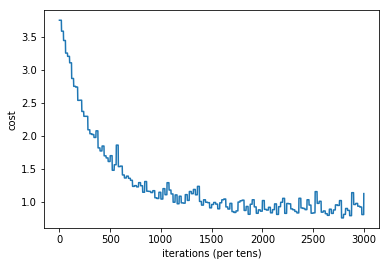

In [9]:
m3=Model3()
train_minibatch(m3, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 3000, imprimir=True)

### 2.1 ANALISIS DEL TAMAÑO DE LAS CAPAS

In [28]:
class Model3():

    def __init__(self,n1,n2,n3):
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global setp counter
            self.global_step = tf.Variable(0, trainable=False,name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32,(None,32, 32,3), name='images')
            self.labels=tf.placeholder(tf.int32, [None], name='labels')
            #Flatten input
            self.images_flat=tf.contrib.layers.flatten(self.images)
            #Fully connected layer
            self.h1=tf.contrib.layers.fully_connected(self.images_flat,n1, lrelu)
            self.h2=tf.contrib.layers.fully_connected(self.h1,n2, lrelu)
            self.logits=tf.contrib.layers.fully_connected(self.h2,n3, lrelu)
            #Convert one hot vector to label indexes (int)
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training
            # Notice that we're passing the gloal_step variable as a parameter.
            # The minimize() function increments it with every training step.
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                        .minimize(self.loss, global_step=self.global_step)
            #Initialization
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run Initialization
            self.session.run(self.init)

In [29]:
def evaluate(model, train_images, test_images, train_labels, test_labels, step, imprimir=True):
    #Run predictions against the full test set
    predicted_train, loss_train = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: train_images, model.labels:train_labels})
    predicted_test, loss_test = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: test_images, model.labels:test_labels})
    #Calculate accuracy and print
    accuracy_train=np.sum(train_labels == predicted_train)/train_labels.shape[0]
    accuracy_test=np.sum(test_labels == predicted_test)/test_labels.shape[0]
    #accuracy=np.sum(labels == predicted)/labels.shape[0]
    if imprimir == True:
        print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(step,loss_train, accuracy_train))
        #print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(step ,loss_test, accuracy_test))
        
    return loss_train

def train_minibatch(model, images, labels, test_images, test_labels, train_counts, imprimir=True):
    #Training loop
    costs = []
    for i in range(train_counts):
        if i % 50 == 0:
            lossvalue = evaluate(model, images, test_images, labels, test_labels, model.session.run(model.global_step),imprimir)
        # ??? improve picking batches
        costs.append(lossvalue)
        indexes = np.random.choice(np.arange(images.shape[0]), 50, replace=False)
        #print("indexes" , indexes.shape)
        model.session.run(model.train,
                          {model.images: images[indexes],
                           model.labels: labels[indexes]})
    # Final evaluation
    lossvalue = evaluate(model, images, test_images, labels, test_labels, model.session.run(model.global_step))
    costs.append(lossvalue)
    
    #if imprimir == True:
        #plot the cost    
    #    plt.plot(np.squeeze(costs))
    #    plt.ylabel('cost')
    #    plt.xlabel('iterations (per tens)')
    #    plt.show()
    
    return costs
        

In [83]:
RESULTADOS2=[]
for i in range(11):
    n1=800-i*70
    for j in range(11):
        n2=600-j*50
        n3=43
        print("***INTENTO ",i,",",j,"***")
        print("n1: ",n1)
        print("n2: ",n2)
        print("n3: ",n3)
        m3 = Model3(n1,n2,n3)
        loss = train_minibatch(m3, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 3000, True)
        y_pred,_ = m3.session.run([m3.predicted_labels, m3.loss],{m3.images: X_test_orig, m3.labels:Y_test_orig})
        acc=np.sum(Y_test_orig == y_pred)/Y_test_orig.shape[0]
        RESULTADOS2.append([n1,n2,n3,acc,y_pred,loss])

***INTENTO  0 , 0 ***
n1:  800
n2:  600
n3:  43
   0, Loss: 3.835  Train accuracy: 0.022
  50, Loss: 3.728  Train accuracy: 0.033
 100, Loss: 3.644  Train accuracy: 0.035
 150, Loss: 3.576  Train accuracy: 0.056
 200, Loss: 3.554  Train accuracy: 0.055
 250, Loss: 3.534  Train accuracy: 0.057
 300, Loss: 3.520  Train accuracy: 0.067
 350, Loss: 3.545  Train accuracy: 0.057
 400, Loss: 3.503  Train accuracy: 0.058
 450, Loss: 3.482  Train accuracy: 0.099
 500, Loss: 3.418  Train accuracy: 0.105
 550, Loss: 3.408  Train accuracy: 0.129
 600, Loss: 3.347  Train accuracy: 0.083
 650, Loss: 3.475  Train accuracy: 0.064
 700, Loss: 3.242  Train accuracy: 0.142
 750, Loss: 3.276  Train accuracy: 0.135
 800, Loss: 3.023  Train accuracy: 0.173
 850, Loss: 2.960  Train accuracy: 0.203
 900, Loss: 2.850  Train accuracy: 0.220
 950, Loss: 2.809  Train accuracy: 0.214
1000, Loss: 2.710  Train accuracy: 0.263
1050, Loss: 2.646  Train accuracy: 0.263
1100, Loss: 2.657  Train accuracy: 0.230
1150, Los

 650, Loss: 3.375  Train accuracy: 0.108
 700, Loss: 3.381  Train accuracy: 0.081
 750, Loss: 3.322  Train accuracy: 0.121
 800, Loss: 3.265  Train accuracy: 0.107
 850, Loss: 3.215  Train accuracy: 0.119
 900, Loss: 3.195  Train accuracy: 0.144
 950, Loss: 3.295  Train accuracy: 0.076
1000, Loss: 3.146  Train accuracy: 0.113
1050, Loss: 3.097  Train accuracy: 0.126
1100, Loss: 3.048  Train accuracy: 0.152
1150, Loss: 2.991  Train accuracy: 0.168
1200, Loss: 3.044  Train accuracy: 0.171
1250, Loss: 2.940  Train accuracy: 0.195
1300, Loss: 2.875  Train accuracy: 0.203
1350, Loss: 2.829  Train accuracy: 0.204
1400, Loss: 2.843  Train accuracy: 0.201
1450, Loss: 2.715  Train accuracy: 0.205
1500, Loss: 2.643  Train accuracy: 0.246
1550, Loss: 2.998  Train accuracy: 0.215
1600, Loss: 2.616  Train accuracy: 0.266
1650, Loss: 2.545  Train accuracy: 0.278
1700, Loss: 2.563  Train accuracy: 0.265
1750, Loss: 2.441  Train accuracy: 0.288
1800, Loss: 2.400  Train accuracy: 0.307
1850, Loss: 2.37

1350, Loss: 0.828  Train accuracy: 0.760
1400, Loss: 0.530  Train accuracy: 0.858
1450, Loss: 0.535  Train accuracy: 0.843
1500, Loss: 0.488  Train accuracy: 0.868
1550, Loss: 0.523  Train accuracy: 0.849
1600, Loss: 0.756  Train accuracy: 0.779
1650, Loss: 0.388  Train accuracy: 0.900
1700, Loss: 0.533  Train accuracy: 0.846
1750, Loss: 0.447  Train accuracy: 0.872
1800, Loss: 0.498  Train accuracy: 0.864
1850, Loss: 0.411  Train accuracy: 0.885
1900, Loss: 0.497  Train accuracy: 0.858
1950, Loss: 0.373  Train accuracy: 0.901
2000, Loss: 0.482  Train accuracy: 0.853
2050, Loss: 0.608  Train accuracy: 0.844
2100, Loss: 0.452  Train accuracy: 0.867
2150, Loss: 0.387  Train accuracy: 0.898
2200, Loss: 0.345  Train accuracy: 0.910
2250, Loss: 0.419  Train accuracy: 0.875
2300, Loss: 0.434  Train accuracy: 0.881
2350, Loss: 0.424  Train accuracy: 0.883
2400, Loss: 0.318  Train accuracy: 0.912
2450, Loss: 0.398  Train accuracy: 0.886
2500, Loss: 0.308  Train accuracy: 0.913
2550, Loss: 0.42

2050, Loss: 0.453  Train accuracy: 0.877
2100, Loss: 0.413  Train accuracy: 0.888
2150, Loss: 0.406  Train accuracy: 0.888
2200, Loss: 0.466  Train accuracy: 0.866
2250, Loss: 0.421  Train accuracy: 0.884
2300, Loss: 0.356  Train accuracy: 0.905
2350, Loss: 0.414  Train accuracy: 0.885
2400, Loss: 0.335  Train accuracy: 0.915
2450, Loss: 0.404  Train accuracy: 0.890
2500, Loss: 0.449  Train accuracy: 0.871
2550, Loss: 0.395  Train accuracy: 0.892
2600, Loss: 0.383  Train accuracy: 0.894
2650, Loss: 0.382  Train accuracy: 0.896
2700, Loss: 0.430  Train accuracy: 0.880
2750, Loss: 0.366  Train accuracy: 0.896
2800, Loss: 0.340  Train accuracy: 0.897
2850, Loss: 0.312  Train accuracy: 0.913
2900, Loss: 0.305  Train accuracy: 0.920
2950, Loss: 0.359  Train accuracy: 0.902
3000, Loss: 0.408  Train accuracy: 0.886
***INTENTO  0 , 10 ***
n1:  800
n2:  100
n3:  43
   0, Loss: 3.816  Train accuracy: 0.029
  50, Loss: 3.555  Train accuracy: 0.132
 100, Loss: 3.303  Train accuracy: 0.259
 150, Lo

2750, Loss: 1.742  Train accuracy: 0.507
2800, Loss: 1.645  Train accuracy: 0.531
2850, Loss: 1.600  Train accuracy: 0.551
2900, Loss: 1.569  Train accuracy: 0.557
2950, Loss: 1.837  Train accuracy: 0.492
3000, Loss: 1.562  Train accuracy: 0.569
***INTENTO  1 , 2 ***
n1:  730
n2:  500
n3:  43
   0, Loss: 3.774  Train accuracy: 0.057
  50, Loss: 3.719  Train accuracy: 0.061
 100, Loss: 3.658  Train accuracy: 0.079
 150, Loss: 3.601  Train accuracy: 0.057
 200, Loss: 3.599  Train accuracy: 0.051
 250, Loss: 3.556  Train accuracy: 0.054
 300, Loss: 3.530  Train accuracy: 0.057
 350, Loss: 3.515  Train accuracy: 0.067
 400, Loss: 3.486  Train accuracy: 0.083
 450, Loss: 3.460  Train accuracy: 0.085
 500, Loss: 3.438  Train accuracy: 0.078
 550, Loss: 3.416  Train accuracy: 0.075
 600, Loss: 3.366  Train accuracy: 0.112
 650, Loss: 3.334  Train accuracy: 0.122
 700, Loss: 3.326  Train accuracy: 0.107
 750, Loss: 3.245  Train accuracy: 0.118
 800, Loss: 3.188  Train accuracy: 0.149
 850, Los

 350, Loss: 3.540  Train accuracy: 0.096
 400, Loss: 3.526  Train accuracy: 0.083
 450, Loss: 3.523  Train accuracy: 0.065
 500, Loss: 3.503  Train accuracy: 0.076
 550, Loss: 3.493  Train accuracy: 0.058
 600, Loss: 3.410  Train accuracy: 0.108
 650, Loss: 3.476  Train accuracy: 0.066
 700, Loss: 3.414  Train accuracy: 0.075
 750, Loss: 3.375  Train accuracy: 0.116
 800, Loss: 3.570  Train accuracy: 0.058
 850, Loss: 3.345  Train accuracy: 0.087
 900, Loss: 3.299  Train accuracy: 0.124
 950, Loss: 3.221  Train accuracy: 0.134
1000, Loss: 3.073  Train accuracy: 0.179
1050, Loss: 2.940  Train accuracy: 0.209
1100, Loss: 2.870  Train accuracy: 0.223
1150, Loss: 2.910  Train accuracy: 0.207
1200, Loss: 2.702  Train accuracy: 0.268
1250, Loss: 2.629  Train accuracy: 0.265
1300, Loss: 2.738  Train accuracy: 0.234
1350, Loss: 3.168  Train accuracy: 0.143
1400, Loss: 2.588  Train accuracy: 0.262
1450, Loss: 2.458  Train accuracy: 0.307
1500, Loss: 2.397  Train accuracy: 0.309
1550, Loss: 2.33

1050, Loss: 0.804  Train accuracy: 0.775
1100, Loss: 0.829  Train accuracy: 0.775
1150, Loss: 0.636  Train accuracy: 0.832
1200, Loss: 0.628  Train accuracy: 0.814
1250, Loss: 0.587  Train accuracy: 0.843
1300, Loss: 0.641  Train accuracy: 0.819
1350, Loss: 0.676  Train accuracy: 0.807
1400, Loss: 0.677  Train accuracy: 0.816
1450, Loss: 0.466  Train accuracy: 0.874
1500, Loss: 0.561  Train accuracy: 0.838
1550, Loss: 0.514  Train accuracy: 0.870
1600, Loss: 0.572  Train accuracy: 0.843
1650, Loss: 0.610  Train accuracy: 0.832
1700, Loss: 0.547  Train accuracy: 0.844
1750, Loss: 0.491  Train accuracy: 0.869
1800, Loss: 0.529  Train accuracy: 0.854
1850, Loss: 0.526  Train accuracy: 0.846
1900, Loss: 0.660  Train accuracy: 0.807
1950, Loss: 0.415  Train accuracy: 0.879
2000, Loss: 0.560  Train accuracy: 0.837
2050, Loss: 0.376  Train accuracy: 0.899
2100, Loss: 0.345  Train accuracy: 0.907
2150, Loss: 0.392  Train accuracy: 0.896
2200, Loss: 0.364  Train accuracy: 0.903
2250, Loss: 0.38

1750, Loss: 2.346  Train accuracy: 0.326
1800, Loss: 2.306  Train accuracy: 0.318
1850, Loss: 2.268  Train accuracy: 0.355
1900, Loss: 2.221  Train accuracy: 0.384
1950, Loss: 2.239  Train accuracy: 0.337
2000, Loss: 2.155  Train accuracy: 0.381
2050, Loss: 2.156  Train accuracy: 0.364
2100, Loss: 2.094  Train accuracy: 0.396
2150, Loss: 2.106  Train accuracy: 0.388
2200, Loss: 2.542  Train accuracy: 0.331
2250, Loss: 2.136  Train accuracy: 0.394
2300, Loss: 2.136  Train accuracy: 0.399
2350, Loss: 2.031  Train accuracy: 0.433
2400, Loss: 1.997  Train accuracy: 0.439
2450, Loss: 2.235  Train accuracy: 0.376
2500, Loss: 1.974  Train accuracy: 0.421
2550, Loss: 1.933  Train accuracy: 0.440
2600, Loss: 1.905  Train accuracy: 0.456
2650, Loss: 1.877  Train accuracy: 0.452
2700, Loss: 1.831  Train accuracy: 0.467
2750, Loss: 1.826  Train accuracy: 0.447
2800, Loss: 1.979  Train accuracy: 0.430
2850, Loss: 1.812  Train accuracy: 0.462
2900, Loss: 1.766  Train accuracy: 0.480
2950, Loss: 1.71

2450, Loss: 2.139  Train accuracy: 0.375
2500, Loss: 1.820  Train accuracy: 0.458
2550, Loss: 1.758  Train accuracy: 0.493
2600, Loss: 1.764  Train accuracy: 0.493
2650, Loss: 1.730  Train accuracy: 0.498
2700, Loss: 1.691  Train accuracy: 0.498
2750, Loss: 1.659  Train accuracy: 0.522
2800, Loss: 1.650  Train accuracy: 0.521
2850, Loss: 1.593  Train accuracy: 0.538
2900, Loss: 1.657  Train accuracy: 0.513
2950, Loss: 1.635  Train accuracy: 0.528
3000, Loss: 1.533  Train accuracy: 0.564
***INTENTO  2 , 4 ***
n1:  660
n2:  400
n3:  43
   0, Loss: 3.800  Train accuracy: 0.025
  50, Loss: 3.636  Train accuracy: 0.099
 100, Loss: 3.571  Train accuracy: 0.121
 150, Loss: 3.588  Train accuracy: 0.078
 200, Loss: 3.488  Train accuracy: 0.118
 250, Loss: 3.419  Train accuracy: 0.132
 300, Loss: 3.349  Train accuracy: 0.154
 350, Loss: 3.299  Train accuracy: 0.121
 400, Loss: 3.356  Train accuracy: 0.171
 450, Loss: 3.305  Train accuracy: 0.137
 500, Loss: 3.280  Train accuracy: 0.125
 550, Los

  50, Loss: 3.551  Train accuracy: 0.124
 100, Loss: 3.323  Train accuracy: 0.215
 150, Loss: 3.107  Train accuracy: 0.267
 200, Loss: 2.910  Train accuracy: 0.269
 250, Loss: 2.336  Train accuracy: 0.436
 300, Loss: 2.128  Train accuracy: 0.478
 350, Loss: 1.897  Train accuracy: 0.550
 400, Loss: 1.647  Train accuracy: 0.600
 450, Loss: 1.665  Train accuracy: 0.616
 500, Loss: 1.474  Train accuracy: 0.658
 550, Loss: 1.316  Train accuracy: 0.667
 600, Loss: 1.075  Train accuracy: 0.736
 650, Loss: 1.100  Train accuracy: 0.712
 700, Loss: 1.052  Train accuracy: 0.722
 750, Loss: 1.356  Train accuracy: 0.641
 800, Loss: 0.887  Train accuracy: 0.762
 850, Loss: 0.783  Train accuracy: 0.788
 900, Loss: 0.720  Train accuracy: 0.803
 950, Loss: 0.794  Train accuracy: 0.781
1000, Loss: 0.750  Train accuracy: 0.798
1050, Loss: 0.659  Train accuracy: 0.828
1100, Loss: 0.718  Train accuracy: 0.813
1150, Loss: 0.628  Train accuracy: 0.833
1200, Loss: 0.598  Train accuracy: 0.835
1250, Loss: 0.69

 750, Loss: 1.233  Train accuracy: 0.684
 800, Loss: 1.148  Train accuracy: 0.713
 850, Loss: 0.981  Train accuracy: 0.766
 900, Loss: 0.965  Train accuracy: 0.761
 950, Loss: 0.927  Train accuracy: 0.770
1000, Loss: 0.981  Train accuracy: 0.735
1050, Loss: 0.869  Train accuracy: 0.758
1100, Loss: 0.753  Train accuracy: 0.812
1150, Loss: 0.814  Train accuracy: 0.771
1200, Loss: 0.811  Train accuracy: 0.780
1250, Loss: 0.685  Train accuracy: 0.807
1300, Loss: 0.675  Train accuracy: 0.814
1350, Loss: 0.764  Train accuracy: 0.794
1400, Loss: 0.688  Train accuracy: 0.798
1450, Loss: 0.684  Train accuracy: 0.809
1500, Loss: 0.671  Train accuracy: 0.816
1550, Loss: 0.636  Train accuracy: 0.815
1600, Loss: 0.543  Train accuracy: 0.854
1650, Loss: 0.542  Train accuracy: 0.855
1700, Loss: 0.530  Train accuracy: 0.865
1750, Loss: 0.573  Train accuracy: 0.848
1800, Loss: 0.980  Train accuracy: 0.740
1850, Loss: 0.465  Train accuracy: 0.884
1900, Loss: 0.572  Train accuracy: 0.837
1950, Loss: 0.63

1450, Loss: 2.503  Train accuracy: 0.286
1500, Loss: 2.479  Train accuracy: 0.255
1550, Loss: 2.667  Train accuracy: 0.287
1600, Loss: 2.405  Train accuracy: 0.306
1650, Loss: 2.361  Train accuracy: 0.280
1700, Loss: 2.293  Train accuracy: 0.312
1750, Loss: 2.296  Train accuracy: 0.355
1800, Loss: 2.271  Train accuracy: 0.352
1850, Loss: 2.212  Train accuracy: 0.379
1900, Loss: 2.234  Train accuracy: 0.329
1950, Loss: 2.159  Train accuracy: 0.379
2000, Loss: 2.084  Train accuracy: 0.392
2050, Loss: 2.059  Train accuracy: 0.416
2100, Loss: 2.003  Train accuracy: 0.416
2150, Loss: 2.054  Train accuracy: 0.381
2200, Loss: 2.088  Train accuracy: 0.410
2250, Loss: 1.956  Train accuracy: 0.421
2300, Loss: 1.910  Train accuracy: 0.440
2350, Loss: 2.047  Train accuracy: 0.406
2400, Loss: 1.865  Train accuracy: 0.460
2450, Loss: 1.821  Train accuracy: 0.472
2500, Loss: 1.851  Train accuracy: 0.436
2550, Loss: 2.425  Train accuracy: 0.315
2600, Loss: 1.861  Train accuracy: 0.451
2650, Loss: 1.77

2150, Loss: 1.994  Train accuracy: 0.430
2200, Loss: 2.028  Train accuracy: 0.422
2250, Loss: 1.955  Train accuracy: 0.448
2300, Loss: 1.929  Train accuracy: 0.451
2350, Loss: 1.850  Train accuracy: 0.468
2400, Loss: 1.849  Train accuracy: 0.469
2450, Loss: 2.643  Train accuracy: 0.323
2500, Loss: 2.153  Train accuracy: 0.366
2550, Loss: 1.778  Train accuracy: 0.508
2600, Loss: 1.724  Train accuracy: 0.536
2650, Loss: 1.739  Train accuracy: 0.486
2700, Loss: 1.653  Train accuracy: 0.515
2750, Loss: 1.658  Train accuracy: 0.539
2800, Loss: 1.583  Train accuracy: 0.565
2850, Loss: 2.173  Train accuracy: 0.410
2900, Loss: 1.600  Train accuracy: 0.565
2950, Loss: 1.536  Train accuracy: 0.567
3000, Loss: 1.689  Train accuracy: 0.556
***INTENTO  3 , 6 ***
n1:  590
n2:  300
n3:  43
   0, Loss: 3.794  Train accuracy: 0.012
  50, Loss: 3.651  Train accuracy: 0.064
 100, Loss: 3.672  Train accuracy: 0.067
 150, Loss: 3.672  Train accuracy: 0.056
 200, Loss: 3.584  Train accuracy: 0.104
 250, Los

2850, Loss: 0.376  Train accuracy: 0.894
2900, Loss: 0.355  Train accuracy: 0.899
2950, Loss: 0.390  Train accuracy: 0.885
3000, Loss: 0.307  Train accuracy: 0.918
***INTENTO  3 , 9 ***
n1:  590
n2:  150
n3:  43
   0, Loss: 3.793  Train accuracy: 0.038
  50, Loss: 3.739  Train accuracy: 0.053
 100, Loss: 3.633  Train accuracy: 0.092
 150, Loss: 3.307  Train accuracy: 0.181
 200, Loss: 3.090  Train accuracy: 0.255
 250, Loss: 2.760  Train accuracy: 0.383
 300, Loss: 2.662  Train accuracy: 0.383
 350, Loss: 2.501  Train accuracy: 0.454
 400, Loss: 2.113  Train accuracy: 0.483
 450, Loss: 1.864  Train accuracy: 0.578
 500, Loss: 1.759  Train accuracy: 0.554
 550, Loss: 1.695  Train accuracy: 0.575
 600, Loss: 1.707  Train accuracy: 0.579
 650, Loss: 1.414  Train accuracy: 0.663
 700, Loss: 1.377  Train accuracy: 0.665
 750, Loss: 1.169  Train accuracy: 0.707
 800, Loss: 1.122  Train accuracy: 0.715
 850, Loss: 0.976  Train accuracy: 0.746
 900, Loss: 0.918  Train accuracy: 0.767
 950, Los

 450, Loss: 1.853  Train accuracy: 0.506
 500, Loss: 1.519  Train accuracy: 0.613
 550, Loss: 1.346  Train accuracy: 0.646
 600, Loss: 1.361  Train accuracy: 0.646
 650, Loss: 1.105  Train accuracy: 0.708
 700, Loss: 1.089  Train accuracy: 0.691
 750, Loss: 0.955  Train accuracy: 0.716
 800, Loss: 0.824  Train accuracy: 0.755
 850, Loss: 0.836  Train accuracy: 0.759
 900, Loss: 0.830  Train accuracy: 0.771
 950, Loss: 0.760  Train accuracy: 0.778
1000, Loss: 0.775  Train accuracy: 0.788
1050, Loss: 0.562  Train accuracy: 0.842
1100, Loss: 0.594  Train accuracy: 0.834
1150, Loss: 0.660  Train accuracy: 0.811
1200, Loss: 0.788  Train accuracy: 0.772
1250, Loss: 0.613  Train accuracy: 0.828
1300, Loss: 0.543  Train accuracy: 0.857
1350, Loss: 0.484  Train accuracy: 0.868
1400, Loss: 0.527  Train accuracy: 0.852
1450, Loss: 0.569  Train accuracy: 0.842
1500, Loss: 0.625  Train accuracy: 0.817
1550, Loss: 0.472  Train accuracy: 0.862
1600, Loss: 0.449  Train accuracy: 0.877
1650, Loss: 0.51

1150, Loss: 2.673  Train accuracy: 0.244
1200, Loss: 2.595  Train accuracy: 0.268
1250, Loss: 2.842  Train accuracy: 0.194
1300, Loss: 2.537  Train accuracy: 0.276
1350, Loss: 2.476  Train accuracy: 0.271
1400, Loss: 2.440  Train accuracy: 0.312
1450, Loss: 2.490  Train accuracy: 0.288
1500, Loss: 2.406  Train accuracy: 0.307
1550, Loss: 2.353  Train accuracy: 0.325
1600, Loss: 2.388  Train accuracy: 0.304
1650, Loss: 2.291  Train accuracy: 0.338
1700, Loss: 2.280  Train accuracy: 0.334
1750, Loss: 2.369  Train accuracy: 0.329
1800, Loss: 2.222  Train accuracy: 0.349
1850, Loss: 2.169  Train accuracy: 0.358
1900, Loss: 2.164  Train accuracy: 0.355
1950, Loss: 2.112  Train accuracy: 0.388
2000, Loss: 2.142  Train accuracy: 0.353
2050, Loss: 2.069  Train accuracy: 0.401
2100, Loss: 2.054  Train accuracy: 0.398
2150, Loss: 2.016  Train accuracy: 0.417
2200, Loss: 1.978  Train accuracy: 0.410
2250, Loss: 1.946  Train accuracy: 0.429
2300, Loss: 1.888  Train accuracy: 0.460
2350, Loss: 1.88

1850, Loss: 0.512  Train accuracy: 0.854
1900, Loss: 0.463  Train accuracy: 0.866
1950, Loss: 0.457  Train accuracy: 0.862
2000, Loss: 0.355  Train accuracy: 0.907
2050, Loss: 0.363  Train accuracy: 0.901
2100, Loss: 0.368  Train accuracy: 0.898
2150, Loss: 0.423  Train accuracy: 0.878
2200, Loss: 0.432  Train accuracy: 0.874
2250, Loss: 0.370  Train accuracy: 0.898
2300, Loss: 0.399  Train accuracy: 0.892
2350, Loss: 0.437  Train accuracy: 0.880
2400, Loss: 0.366  Train accuracy: 0.892
2450, Loss: 0.413  Train accuracy: 0.882
2500, Loss: 0.477  Train accuracy: 0.861
2550, Loss: 0.345  Train accuracy: 0.904
2600, Loss: 0.416  Train accuracy: 0.874
2650, Loss: 0.348  Train accuracy: 0.895
2700, Loss: 0.291  Train accuracy: 0.916
2750, Loss: 0.292  Train accuracy: 0.919
2800, Loss: 0.417  Train accuracy: 0.872
2850, Loss: 0.306  Train accuracy: 0.912
2900, Loss: 0.264  Train accuracy: 0.926
2950, Loss: 0.332  Train accuracy: 0.909
3000, Loss: 0.285  Train accuracy: 0.921
***INTENTO  4 , 

2550, Loss: 0.378  Train accuracy: 0.904
2600, Loss: 0.415  Train accuracy: 0.886
2650, Loss: 0.471  Train accuracy: 0.865
2700, Loss: 0.415  Train accuracy: 0.887
2750, Loss: 0.408  Train accuracy: 0.888
2800, Loss: 0.374  Train accuracy: 0.897
2850, Loss: 0.355  Train accuracy: 0.903
2900, Loss: 0.352  Train accuracy: 0.907
2950, Loss: 0.509  Train accuracy: 0.852
3000, Loss: 0.387  Train accuracy: 0.898
***INTENTO  5 , 0 ***
n1:  450
n2:  600
n3:  43
   0, Loss: 3.803  Train accuracy: 0.029
  50, Loss: 3.725  Train accuracy: 0.087
 100, Loss: 3.655  Train accuracy: 0.070
 150, Loss: 3.562  Train accuracy: 0.072
 200, Loss: 3.585  Train accuracy: 0.076
 250, Loss: 3.556  Train accuracy: 0.057
 300, Loss: 3.546  Train accuracy: 0.054
 350, Loss: 3.529  Train accuracy: 0.063
 400, Loss: 3.522  Train accuracy: 0.058
 450, Loss: 3.511  Train accuracy: 0.112
 500, Loss: 3.502  Train accuracy: 0.057
 550, Loss: 3.483  Train accuracy: 0.123
 600, Loss: 3.378  Train accuracy: 0.112
 650, Los

 150, Loss: 3.609  Train accuracy: 0.063
 200, Loss: 3.567  Train accuracy: 0.081
 250, Loss: 3.564  Train accuracy: 0.054
 300, Loss: 3.539  Train accuracy: 0.054
 350, Loss: 3.533  Train accuracy: 0.057
 400, Loss: 3.514  Train accuracy: 0.076
 450, Loss: 3.499  Train accuracy: 0.087
 500, Loss: 3.482  Train accuracy: 0.103
 550, Loss: 3.442  Train accuracy: 0.078
 600, Loss: 3.411  Train accuracy: 0.129
 650, Loss: 3.365  Train accuracy: 0.124
 700, Loss: 3.339  Train accuracy: 0.068
 750, Loss: 3.220  Train accuracy: 0.140
 800, Loss: 3.219  Train accuracy: 0.089
 850, Loss: 3.096  Train accuracy: 0.188
 900, Loss: 3.072  Train accuracy: 0.177
 950, Loss: 3.005  Train accuracy: 0.189
1000, Loss: 2.949  Train accuracy: 0.176
1050, Loss: 2.853  Train accuracy: 0.207
1100, Loss: 2.772  Train accuracy: 0.201
1150, Loss: 2.810  Train accuracy: 0.209
1200, Loss: 2.684  Train accuracy: 0.245
1250, Loss: 2.706  Train accuracy: 0.251
1300, Loss: 2.549  Train accuracy: 0.266
1350, Loss: 2.83

 850, Loss: 3.373  Train accuracy: 0.125
 900, Loss: 3.369  Train accuracy: 0.103
 950, Loss: 3.285  Train accuracy: 0.148
1000, Loss: 3.233  Train accuracy: 0.141
1050, Loss: 3.167  Train accuracy: 0.171
1100, Loss: 3.121  Train accuracy: 0.171
1150, Loss: 3.084  Train accuracy: 0.182
1200, Loss: 3.131  Train accuracy: 0.127
1250, Loss: 2.967  Train accuracy: 0.192
1300, Loss: 2.904  Train accuracy: 0.185
1350, Loss: 2.848  Train accuracy: 0.227
1400, Loss: 2.969  Train accuracy: 0.210
1450, Loss: 2.781  Train accuracy: 0.223
1500, Loss: 2.855  Train accuracy: 0.237
1550, Loss: 2.716  Train accuracy: 0.255
1600, Loss: 2.679  Train accuracy: 0.258
1650, Loss: 2.646  Train accuracy: 0.224
1700, Loss: 2.598  Train accuracy: 0.248
1750, Loss: 2.708  Train accuracy: 0.254
1800, Loss: 2.559  Train accuracy: 0.274
1850, Loss: 3.231  Train accuracy: 0.136
1900, Loss: 2.550  Train accuracy: 0.267
1950, Loss: 2.465  Train accuracy: 0.294
2000, Loss: 2.447  Train accuracy: 0.295
2050, Loss: 2.41

1550, Loss: 0.435  Train accuracy: 0.887
1600, Loss: 0.533  Train accuracy: 0.852
1650, Loss: 0.488  Train accuracy: 0.868
1700, Loss: 0.454  Train accuracy: 0.883
1750, Loss: 0.571  Train accuracy: 0.851
1800, Loss: 0.497  Train accuracy: 0.870
1850, Loss: 0.406  Train accuracy: 0.890
1900, Loss: 0.429  Train accuracy: 0.887
1950, Loss: 0.426  Train accuracy: 0.882
2000, Loss: 0.519  Train accuracy: 0.854
2050, Loss: 0.519  Train accuracy: 0.848
2100, Loss: 0.400  Train accuracy: 0.889
2150, Loss: 0.437  Train accuracy: 0.872
2200, Loss: 0.382  Train accuracy: 0.899
2250, Loss: 0.491  Train accuracy: 0.855
2300, Loss: 0.518  Train accuracy: 0.854
2350, Loss: 0.388  Train accuracy: 0.889
2400, Loss: 0.402  Train accuracy: 0.886
2450, Loss: 0.406  Train accuracy: 0.884
2500, Loss: 0.422  Train accuracy: 0.882
2550, Loss: 0.406  Train accuracy: 0.887
2600, Loss: 0.426  Train accuracy: 0.871
2650, Loss: 0.325  Train accuracy: 0.917
2700, Loss: 0.380  Train accuracy: 0.898
2750, Loss: 0.45

2250, Loss: 1.988  Train accuracy: 0.449
2300, Loss: 1.931  Train accuracy: 0.450
2350, Loss: 2.128  Train accuracy: 0.366
2400, Loss: 1.899  Train accuracy: 0.472
2450, Loss: 1.983  Train accuracy: 0.428
2500, Loss: 1.999  Train accuracy: 0.411
2550, Loss: 1.809  Train accuracy: 0.487
2600, Loss: 1.759  Train accuracy: 0.508
2650, Loss: 1.701  Train accuracy: 0.507
2700, Loss: 2.285  Train accuracy: 0.331
2750, Loss: 1.690  Train accuracy: 0.498
2800, Loss: 1.663  Train accuracy: 0.529
2850, Loss: 1.740  Train accuracy: 0.484
2900, Loss: 1.617  Train accuracy: 0.532
2950, Loss: 1.577  Train accuracy: 0.559
3000, Loss: 1.541  Train accuracy: 0.556
***INTENTO  6 , 2 ***
n1:  380
n2:  500
n3:  43
   0, Loss: 3.778  Train accuracy: 0.023
  50, Loss: 3.707  Train accuracy: 0.065
 100, Loss: 3.652  Train accuracy: 0.057
 150, Loss: 3.608  Train accuracy: 0.109
 200, Loss: 3.610  Train accuracy: 0.056
 250, Loss: 3.577  Train accuracy: 0.065
 300, Loss: 3.577  Train accuracy: 0.054
 350, Los

2950, Loss: 0.383  Train accuracy: 0.888
3000, Loss: 0.400  Train accuracy: 0.884
***INTENTO  6 , 5 ***
n1:  380
n2:  350
n3:  43
   0, Loss: 3.802  Train accuracy: 0.010
  50, Loss: 3.714  Train accuracy: 0.040
 100, Loss: 3.625  Train accuracy: 0.072
 150, Loss: 3.089  Train accuracy: 0.278
 200, Loss: 2.667  Train accuracy: 0.365
 250, Loss: 2.236  Train accuracy: 0.469
 300, Loss: 1.997  Train accuracy: 0.529
 350, Loss: 1.819  Train accuracy: 0.550
 400, Loss: 1.680  Train accuracy: 0.553
 450, Loss: 1.474  Train accuracy: 0.619
 500, Loss: 1.282  Train accuracy: 0.671
 550, Loss: 1.176  Train accuracy: 0.705
 600, Loss: 1.098  Train accuracy: 0.719
 650, Loss: 1.056  Train accuracy: 0.715
 700, Loss: 1.020  Train accuracy: 0.705
 750, Loss: 0.960  Train accuracy: 0.729
 800, Loss: 0.815  Train accuracy: 0.785
 850, Loss: 0.717  Train accuracy: 0.810
 900, Loss: 0.781  Train accuracy: 0.785
 950, Loss: 0.661  Train accuracy: 0.821
1000, Loss: 0.629  Train accuracy: 0.827
1050, Los

 550, Loss: 1.107  Train accuracy: 0.709
 600, Loss: 1.148  Train accuracy: 0.687
 650, Loss: 0.962  Train accuracy: 0.729
 700, Loss: 0.884  Train accuracy: 0.764
 750, Loss: 0.867  Train accuracy: 0.783
 800, Loss: 0.824  Train accuracy: 0.774
 850, Loss: 0.774  Train accuracy: 0.788
 900, Loss: 1.001  Train accuracy: 0.726
 950, Loss: 0.678  Train accuracy: 0.828
1000, Loss: 0.821  Train accuracy: 0.767
1050, Loss: 0.663  Train accuracy: 0.805
1100, Loss: 0.602  Train accuracy: 0.825
1150, Loss: 0.628  Train accuracy: 0.828
1200, Loss: 0.589  Train accuracy: 0.828
1250, Loss: 0.672  Train accuracy: 0.802
1300, Loss: 0.567  Train accuracy: 0.839
1350, Loss: 0.617  Train accuracy: 0.830
1400, Loss: 0.558  Train accuracy: 0.847
1450, Loss: 0.439  Train accuracy: 0.890
1500, Loss: 0.489  Train accuracy: 0.870
1550, Loss: 0.502  Train accuracy: 0.863
1600, Loss: 0.540  Train accuracy: 0.843
1650, Loss: 0.497  Train accuracy: 0.857
1700, Loss: 0.506  Train accuracy: 0.862
1750, Loss: 0.55

1250, Loss: 0.538  Train accuracy: 0.843
1300, Loss: 0.604  Train accuracy: 0.829
1350, Loss: 0.573  Train accuracy: 0.836
1400, Loss: 0.490  Train accuracy: 0.858
1450, Loss: 0.515  Train accuracy: 0.861
1500, Loss: 0.382  Train accuracy: 0.899
1550, Loss: 0.431  Train accuracy: 0.885
1600, Loss: 0.468  Train accuracy: 0.856
1650, Loss: 0.453  Train accuracy: 0.875
1700, Loss: 0.447  Train accuracy: 0.865
1750, Loss: 0.508  Train accuracy: 0.862
1800, Loss: 0.543  Train accuracy: 0.835
1850, Loss: 0.349  Train accuracy: 0.904
1900, Loss: 0.453  Train accuracy: 0.869
1950, Loss: 0.414  Train accuracy: 0.884
2000, Loss: 0.534  Train accuracy: 0.853
2050, Loss: 0.383  Train accuracy: 0.896
2100, Loss: 0.469  Train accuracy: 0.861
2150, Loss: 0.358  Train accuracy: 0.900
2200, Loss: 0.405  Train accuracy: 0.883
2250, Loss: 0.347  Train accuracy: 0.905
2300, Loss: 0.340  Train accuracy: 0.902
2350, Loss: 0.595  Train accuracy: 0.823
2400, Loss: 0.356  Train accuracy: 0.896
2450, Loss: 0.35

1950, Loss: 2.249  Train accuracy: 0.348
2000, Loss: 2.220  Train accuracy: 0.350
2050, Loss: 2.575  Train accuracy: 0.302
2100, Loss: 2.273  Train accuracy: 0.313
2150, Loss: 2.177  Train accuracy: 0.372
2200, Loss: 2.160  Train accuracy: 0.375
2250, Loss: 2.132  Train accuracy: 0.382
2300, Loss: 2.108  Train accuracy: 0.396
2350, Loss: 2.110  Train accuracy: 0.369
2400, Loss: 2.055  Train accuracy: 0.390
2450, Loss: 2.041  Train accuracy: 0.393
2500, Loss: 2.008  Train accuracy: 0.408
2550, Loss: 1.995  Train accuracy: 0.424
2600, Loss: 1.963  Train accuracy: 0.410
2650, Loss: 1.943  Train accuracy: 0.441
2700, Loss: 1.911  Train accuracy: 0.442
2750, Loss: 1.891  Train accuracy: 0.444
2800, Loss: 1.850  Train accuracy: 0.457
2850, Loss: 1.991  Train accuracy: 0.423
2900, Loss: 1.848  Train accuracy: 0.440
2950, Loss: 1.820  Train accuracy: 0.461
3000, Loss: 1.803  Train accuracy: 0.463
***INTENTO  7 , 4 ***
n1:  310
n2:  400
n3:  43
   0, Loss: 3.755  Train accuracy: 0.025
  50, Los

2650, Loss: 0.377  Train accuracy: 0.891
2700, Loss: 0.290  Train accuracy: 0.921
2750, Loss: 0.482  Train accuracy: 0.861
2800, Loss: 0.393  Train accuracy: 0.884
2850, Loss: 0.294  Train accuracy: 0.920
2900, Loss: 0.313  Train accuracy: 0.915
2950, Loss: 0.295  Train accuracy: 0.912
3000, Loss: 0.275  Train accuracy: 0.924
***INTENTO  7 , 7 ***
n1:  310
n2:  250
n3:  43
   0, Loss: 3.773  Train accuracy: 0.040
  50, Loss: 3.536  Train accuracy: 0.145
 100, Loss: 3.139  Train accuracy: 0.286
 150, Loss: 2.909  Train accuracy: 0.291
 200, Loss: 2.484  Train accuracy: 0.393
 250, Loss: 2.249  Train accuracy: 0.495
 300, Loss: 2.042  Train accuracy: 0.502
 350, Loss: 1.762  Train accuracy: 0.579
 400, Loss: 1.624  Train accuracy: 0.596
 450, Loss: 1.401  Train accuracy: 0.639
 500, Loss: 1.328  Train accuracy: 0.665
 550, Loss: 1.137  Train accuracy: 0.682
 600, Loss: 1.050  Train accuracy: 0.724
 650, Loss: 1.173  Train accuracy: 0.692
 700, Loss: 1.192  Train accuracy: 0.664
 750, Los

 250, Loss: 2.294  Train accuracy: 0.455
 300, Loss: 2.232  Train accuracy: 0.508
 350, Loss: 2.003  Train accuracy: 0.542
 400, Loss: 1.864  Train accuracy: 0.550
 450, Loss: 1.703  Train accuracy: 0.580
 500, Loss: 1.638  Train accuracy: 0.608
 550, Loss: 1.453  Train accuracy: 0.624
 600, Loss: 1.320  Train accuracy: 0.681
 650, Loss: 1.280  Train accuracy: 0.667
 700, Loss: 1.106  Train accuracy: 0.726
 750, Loss: 1.095  Train accuracy: 0.706
 800, Loss: 1.076  Train accuracy: 0.724
 850, Loss: 1.088  Train accuracy: 0.727
 900, Loss: 0.937  Train accuracy: 0.770
 950, Loss: 0.992  Train accuracy: 0.754
1000, Loss: 0.867  Train accuracy: 0.773
1050, Loss: 0.841  Train accuracy: 0.755
1100, Loss: 0.706  Train accuracy: 0.822
1150, Loss: 0.775  Train accuracy: 0.796
1200, Loss: 0.785  Train accuracy: 0.796
1250, Loss: 0.665  Train accuracy: 0.841
1300, Loss: 0.645  Train accuracy: 0.824
1350, Loss: 0.668  Train accuracy: 0.818
1400, Loss: 0.606  Train accuracy: 0.846
1450, Loss: 0.64

 950, Loss: 0.625  Train accuracy: 0.825
1000, Loss: 0.597  Train accuracy: 0.827
1050, Loss: 0.569  Train accuracy: 0.846
1100, Loss: 0.606  Train accuracy: 0.832
1150, Loss: 0.573  Train accuracy: 0.836
1200, Loss: 0.598  Train accuracy: 0.843
1250, Loss: 0.508  Train accuracy: 0.866
1300, Loss: 0.409  Train accuracy: 0.895
1350, Loss: 0.411  Train accuracy: 0.891
1400, Loss: 0.498  Train accuracy: 0.866
1450, Loss: 0.425  Train accuracy: 0.888
1500, Loss: 0.469  Train accuracy: 0.864
1550, Loss: 0.474  Train accuracy: 0.865
1600, Loss: 0.536  Train accuracy: 0.839
1650, Loss: 0.383  Train accuracy: 0.893
1700, Loss: 0.390  Train accuracy: 0.891
1750, Loss: 0.357  Train accuracy: 0.902
1800, Loss: 0.517  Train accuracy: 0.852
1850, Loss: 0.376  Train accuracy: 0.897
1900, Loss: 0.453  Train accuracy: 0.876
1950, Loss: 0.455  Train accuracy: 0.869
2000, Loss: 0.366  Train accuracy: 0.900
2050, Loss: 0.355  Train accuracy: 0.901
2100, Loss: 0.385  Train accuracy: 0.891
2150, Loss: 0.44

1650, Loss: 0.517  Train accuracy: 0.861
1700, Loss: 0.486  Train accuracy: 0.864
1750, Loss: 0.494  Train accuracy: 0.864
1800, Loss: 0.522  Train accuracy: 0.852
1850, Loss: 0.505  Train accuracy: 0.861
1900, Loss: 0.513  Train accuracy: 0.854
1950, Loss: 0.481  Train accuracy: 0.869
2000, Loss: 0.431  Train accuracy: 0.876
2050, Loss: 0.481  Train accuracy: 0.863
2100, Loss: 0.393  Train accuracy: 0.896
2150, Loss: 0.449  Train accuracy: 0.870
2200, Loss: 0.432  Train accuracy: 0.878
2250, Loss: 0.454  Train accuracy: 0.876
2300, Loss: 0.469  Train accuracy: 0.867
2350, Loss: 0.334  Train accuracy: 0.917
2400, Loss: 0.423  Train accuracy: 0.877
2450, Loss: 0.369  Train accuracy: 0.895
2500, Loss: 0.464  Train accuracy: 0.873
2550, Loss: 0.494  Train accuracy: 0.854
2600, Loss: 0.354  Train accuracy: 0.905
2650, Loss: 0.518  Train accuracy: 0.845
2700, Loss: 0.444  Train accuracy: 0.880
2750, Loss: 0.489  Train accuracy: 0.856
2800, Loss: 0.436  Train accuracy: 0.873
2850, Loss: 0.46

2350, Loss: 0.452  Train accuracy: 0.875
2400, Loss: 0.325  Train accuracy: 0.916
2450, Loss: 0.442  Train accuracy: 0.878
2500, Loss: 0.344  Train accuracy: 0.907
2550, Loss: 0.372  Train accuracy: 0.893
2600, Loss: 0.306  Train accuracy: 0.922
2650, Loss: 0.370  Train accuracy: 0.901
2700, Loss: 0.378  Train accuracy: 0.894
2750, Loss: 0.467  Train accuracy: 0.884
2800, Loss: 0.388  Train accuracy: 0.888
2850, Loss: 0.527  Train accuracy: 0.851
2900, Loss: 0.327  Train accuracy: 0.909
2950, Loss: 0.315  Train accuracy: 0.917
3000, Loss: 0.315  Train accuracy: 0.915
***INTENTO  8 , 9 ***
n1:  240
n2:  150
n3:  43
   0, Loss: 3.779  Train accuracy: 0.029
  50, Loss: 3.564  Train accuracy: 0.114
 100, Loss: 3.357  Train accuracy: 0.188
 150, Loss: 2.945  Train accuracy: 0.339
 200, Loss: 2.602  Train accuracy: 0.402
 250, Loss: 2.322  Train accuracy: 0.495
 300, Loss: 2.080  Train accuracy: 0.513
 350, Loss: 1.901  Train accuracy: 0.559
 400, Loss: 1.950  Train accuracy: 0.502
 450, Los

***INTENTO  9 , 1 ***
n1:  170
n2:  550
n3:  43
   0, Loss: 3.766  Train accuracy: 0.018
  50, Loss: 3.519  Train accuracy: 0.135
 100, Loss: 3.076  Train accuracy: 0.236
 150, Loss: 2.601  Train accuracy: 0.348
 200, Loss: 2.313  Train accuracy: 0.455
 250, Loss: 2.039  Train accuracy: 0.485
 300, Loss: 1.779  Train accuracy: 0.522
 350, Loss: 1.777  Train accuracy: 0.544
 400, Loss: 1.339  Train accuracy: 0.645
 450, Loss: 1.304  Train accuracy: 0.642
 500, Loss: 1.212  Train accuracy: 0.676
 550, Loss: 1.285  Train accuracy: 0.624
 600, Loss: 0.965  Train accuracy: 0.723
 650, Loss: 0.911  Train accuracy: 0.739
 700, Loss: 0.834  Train accuracy: 0.769
 750, Loss: 0.847  Train accuracy: 0.773
 800, Loss: 0.849  Train accuracy: 0.753
 850, Loss: 0.857  Train accuracy: 0.772
 900, Loss: 0.729  Train accuracy: 0.802
 950, Loss: 0.658  Train accuracy: 0.820
1000, Loss: 1.006  Train accuracy: 0.689
1050, Loss: 0.708  Train accuracy: 0.797
1100, Loss: 0.651  Train accuracy: 0.815
1150, Los

 650, Loss: 0.884  Train accuracy: 0.769
 700, Loss: 0.917  Train accuracy: 0.747
 750, Loss: 0.888  Train accuracy: 0.757
 800, Loss: 0.765  Train accuracy: 0.795
 850, Loss: 0.806  Train accuracy: 0.767
 900, Loss: 1.017  Train accuracy: 0.724
 950, Loss: 0.735  Train accuracy: 0.802
1000, Loss: 0.682  Train accuracy: 0.804
1050, Loss: 0.653  Train accuracy: 0.827
1100, Loss: 0.620  Train accuracy: 0.838
1150, Loss: 0.565  Train accuracy: 0.848
1200, Loss: 0.720  Train accuracy: 0.790
1250, Loss: 0.588  Train accuracy: 0.832
1300, Loss: 0.605  Train accuracy: 0.837
1350, Loss: 0.500  Train accuracy: 0.862
1400, Loss: 0.495  Train accuracy: 0.875
1450, Loss: 0.445  Train accuracy: 0.886
1500, Loss: 0.446  Train accuracy: 0.883
1550, Loss: 0.552  Train accuracy: 0.845
1600, Loss: 0.434  Train accuracy: 0.880
1650, Loss: 0.413  Train accuracy: 0.890
1700, Loss: 0.664  Train accuracy: 0.805
1750, Loss: 0.428  Train accuracy: 0.883
1800, Loss: 0.558  Train accuracy: 0.853
1850, Loss: 0.66

1350, Loss: 0.543  Train accuracy: 0.853
1400, Loss: 0.598  Train accuracy: 0.822
1450, Loss: 0.787  Train accuracy: 0.787
1500, Loss: 0.649  Train accuracy: 0.811
1550, Loss: 0.640  Train accuracy: 0.815
1600, Loss: 0.474  Train accuracy: 0.866
1650, Loss: 0.524  Train accuracy: 0.852
1700, Loss: 0.529  Train accuracy: 0.851
1750, Loss: 0.896  Train accuracy: 0.761
1800, Loss: 0.458  Train accuracy: 0.872
1850, Loss: 0.461  Train accuracy: 0.875
1900, Loss: 0.789  Train accuracy: 0.777
1950, Loss: 0.498  Train accuracy: 0.854
2000, Loss: 0.428  Train accuracy: 0.879
2050, Loss: 0.389  Train accuracy: 0.899
2100, Loss: 0.528  Train accuracy: 0.854
2150, Loss: 0.439  Train accuracy: 0.883
2200, Loss: 0.405  Train accuracy: 0.888
2250, Loss: 0.467  Train accuracy: 0.861
2300, Loss: 0.411  Train accuracy: 0.891
2350, Loss: 0.408  Train accuracy: 0.893
2400, Loss: 0.415  Train accuracy: 0.884
2450, Loss: 0.386  Train accuracy: 0.892
2500, Loss: 0.433  Train accuracy: 0.875
2550, Loss: 0.41

2050, Loss: 0.448  Train accuracy: 0.879
2100, Loss: 0.517  Train accuracy: 0.865
2150, Loss: 0.507  Train accuracy: 0.855
2200, Loss: 0.452  Train accuracy: 0.880
2250, Loss: 0.420  Train accuracy: 0.884
2300, Loss: 0.356  Train accuracy: 0.911
2350, Loss: 0.360  Train accuracy: 0.907
2400, Loss: 0.462  Train accuracy: 0.877
2450, Loss: 0.438  Train accuracy: 0.880
2500, Loss: 0.341  Train accuracy: 0.913
2550, Loss: 0.462  Train accuracy: 0.865
2600, Loss: 0.542  Train accuracy: 0.843
2650, Loss: 0.456  Train accuracy: 0.879
2700, Loss: 0.393  Train accuracy: 0.895
2750, Loss: 0.422  Train accuracy: 0.888
2800, Loss: 0.423  Train accuracy: 0.887
2850, Loss: 0.372  Train accuracy: 0.899
2900, Loss: 0.366  Train accuracy: 0.901
2950, Loss: 0.392  Train accuracy: 0.887
3000, Loss: 0.407  Train accuracy: 0.902
***INTENTO  10 , 0 ***
n1:  100
n2:  600
n3:  43
   0, Loss: 3.757  Train accuracy: 0.025
  50, Loss: 3.419  Train accuracy: 0.157
 100, Loss: 2.985  Train accuracy: 0.253
 150, Lo

2750, Loss: 0.303  Train accuracy: 0.916
2800, Loss: 0.436  Train accuracy: 0.881
2850, Loss: 0.492  Train accuracy: 0.856
2900, Loss: 0.330  Train accuracy: 0.906
2950, Loss: 0.369  Train accuracy: 0.902
3000, Loss: 0.277  Train accuracy: 0.929
***INTENTO  10 , 3 ***
n1:  100
n2:  450
n3:  43
   0, Loss: 3.773  Train accuracy: 0.020
  50, Loss: 3.367  Train accuracy: 0.197
 100, Loss: 2.998  Train accuracy: 0.270
 150, Loss: 2.595  Train accuracy: 0.377
 200, Loss: 2.321  Train accuracy: 0.457
 250, Loss: 2.040  Train accuracy: 0.489
 300, Loss: 1.807  Train accuracy: 0.558
 350, Loss: 1.604  Train accuracy: 0.603
 400, Loss: 1.502  Train accuracy: 0.602
 450, Loss: 1.369  Train accuracy: 0.602
 500, Loss: 1.191  Train accuracy: 0.684
 550, Loss: 1.122  Train accuracy: 0.697
 600, Loss: 1.159  Train accuracy: 0.686
 650, Loss: 0.912  Train accuracy: 0.746
 700, Loss: 1.012  Train accuracy: 0.705
 750, Loss: 0.826  Train accuracy: 0.769
 800, Loss: 0.785  Train accuracy: 0.789
 850, Lo

 350, Loss: 1.552  Train accuracy: 0.580
 400, Loss: 1.468  Train accuracy: 0.600
 450, Loss: 1.300  Train accuracy: 0.657
 500, Loss: 1.250  Train accuracy: 0.658
 550, Loss: 1.022  Train accuracy: 0.725
 600, Loss: 1.080  Train accuracy: 0.676
 650, Loss: 0.966  Train accuracy: 0.742
 700, Loss: 0.932  Train accuracy: 0.718
 750, Loss: 0.882  Train accuracy: 0.755
 800, Loss: 0.989  Train accuracy: 0.706
 850, Loss: 0.880  Train accuracy: 0.736
 900, Loss: 0.697  Train accuracy: 0.808
 950, Loss: 0.677  Train accuracy: 0.824
1000, Loss: 0.737  Train accuracy: 0.778
1050, Loss: 0.617  Train accuracy: 0.845
1100, Loss: 0.747  Train accuracy: 0.780
1150, Loss: 0.613  Train accuracy: 0.833
1200, Loss: 0.779  Train accuracy: 0.788
1250, Loss: 0.605  Train accuracy: 0.832
1300, Loss: 0.667  Train accuracy: 0.833
1350, Loss: 0.527  Train accuracy: 0.867
1400, Loss: 0.502  Train accuracy: 0.873
1450, Loss: 0.565  Train accuracy: 0.842
1500, Loss: 0.696  Train accuracy: 0.796
1550, Loss: 0.57

1050, Loss: 0.856  Train accuracy: 0.754
1100, Loss: 0.886  Train accuracy: 0.755
1150, Loss: 0.895  Train accuracy: 0.743
1200, Loss: 0.715  Train accuracy: 0.813
1250, Loss: 0.812  Train accuracy: 0.770
1300, Loss: 0.706  Train accuracy: 0.818
1350, Loss: 0.694  Train accuracy: 0.810
1400, Loss: 0.616  Train accuracy: 0.837
1450, Loss: 0.738  Train accuracy: 0.792
1500, Loss: 0.682  Train accuracy: 0.823
1550, Loss: 0.656  Train accuracy: 0.818
1600, Loss: 0.590  Train accuracy: 0.850
1650, Loss: 0.595  Train accuracy: 0.843
1700, Loss: 0.619  Train accuracy: 0.825
1750, Loss: 0.578  Train accuracy: 0.848
1800, Loss: 0.656  Train accuracy: 0.820
1850, Loss: 0.545  Train accuracy: 0.848
1900, Loss: 0.694  Train accuracy: 0.810
1950, Loss: 0.639  Train accuracy: 0.820
2000, Loss: 0.473  Train accuracy: 0.881
2050, Loss: 0.527  Train accuracy: 0.859
2100, Loss: 0.492  Train accuracy: 0.864
2150, Loss: 0.471  Train accuracy: 0.879
2200, Loss: 0.464  Train accuracy: 0.880
2250, Loss: 0.44

In [96]:
X1=[]
Y1=[]
Z1=[]
for i in range(len(RESULTADOS2)):
    X1.append(RESULTADOS2[i][0])
    Y1.append(RESULTADOS2[i][1])
    Z1.append(RESULTADOS2[i][3])

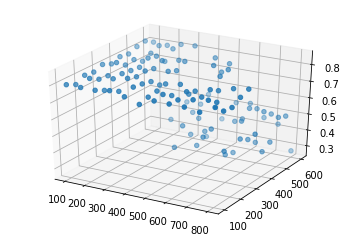

In [97]:
fig = plt.figure()
ax3d = fig.add_subplot(111,projection='3d')
ax3d.scatter(X1,Y1,Z1,zdir='z')

### 2.2 OPTIMIZACIÓN

In [9]:
# TensorFlow doesn't have a native implementation of Leaky-ReLU
# that I know of. But it's simple enough to add it.
def lrelu(x):
    return tf.maximum(0.01*x,x)

In [10]:
class Model3_1():

    def __init__(self,n1,n2,n3):
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global setp counter
            self.global_step = tf.Variable(0, trainable=False,name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32,(None,32, 32,3), name='images')
            self.labels=tf.placeholder(tf.int32, [None], name='labels')
            #Flatten input
            self.images_flat=tf.contrib.layers.flatten(self.images)
            #Fully connected layer
            self.h1=tf.contrib.layers.fully_connected(self.images_flat,n1, lrelu)
            self.h2=tf.contrib.layers.fully_connected(self.h1,n2, lrelu)
            self.logits=tf.contrib.layers.fully_connected(self.h2,n3, lrelu)
            #Convert one hot vector to label indexes (int)
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training
            # Notice that we're passing the gloal_step variable as a parameter.
            # The minimize() function increments it with every training step.
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                        .minimize(self.loss, global_step=self.global_step)
            #Initialization
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run Initialization
            self.session.run(self.init)

In [11]:
def evaluate(model, images, labels, imprimir=True):
    #Run predictions against the full test set
    #print(images.shape)
    #print(labels.shape)
    predicted, loss = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: images, model.labels:labels})
    #Calculate accuracy and print
    accuracy=np.sum(labels == predicted)/labels.shape[0]

    return loss, accuracy 

def train_minibatch(model, images, labels, test_images, test_labels, train_counts, imprimir=True):
    #Training loop
    costs_test=[]
    acc_test=[]
    costs_train=[]
    acc_train=[]
    for i in range(train_counts):
        if i % 50 == 0:
            loss_test, accuracy_test = evaluate(model, test_images, test_labels, imprimir)
            costs_test.append(loss_test)
            acc_test.append(accuracy_test)
            loss_train, accuracy_train = evaluate(model, images, labels, imprimir)
            costs_train.append(loss_train)
            acc_train.append(accuracy_train)
            a = model.session.run(model.global_step)
            if imprimir == True:
                print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(a,loss_train, accuracy_train))
                print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(a,loss_test, accuracy_test))
        # ??? improve picking batches
        indexes = np.random.choice(np.arange(images.shape[0]), 50, replace=False)
        #print("indexes" , indexes.shape)
        model.session.run(model.train,
                          {model.images: images[indexes],
                           model.labels: labels[indexes]})
    # Final evaluation
    loss_train, accuracy_train = evaluate(model, images, labels, imprimir)
    costs_train.append(loss_train)
    acc_train.append(accuracy_train)
    
    loss_test, accuracy_test = evaluate(model, test_images, test_labels, imprimir)
    costs_test.append(loss_test)
    acc_test.append(accuracy_test)
    
    print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(a,loss_train, accuracy_train))
    print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(a,loss_test, accuracy_test))
    
    prec_max=max(acc_train)
    prec_max_local = 0
    b = 0
    #print('prec_max',prec_max)
    
    while prec_max > prec_max_local:
        indexes = np.random.choice(np.arange(images.shape[0]), 50, replace=False)
        #print("indexes" , indexes.shape)
        model.session.run(model.train,
                          {model.images: images[indexes],
                           model.labels: labels[indexes]})

        loss_train, accuracy_train = evaluate(model, images, labels, imprimir)
        #if imprimir == True:
            #print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(a,loss_train, accuracy_train))
            #print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(a,loss_test, accuracy_test))
        
        prec_max_local = accuracy_train
        #print(prec_max_local)
        if b > 1000:
            
            break
            
        
        b += 1
        #print('a',b)
        
    loss_test, accuracy_test = evaluate(model, test_images, test_labels, imprimir)
    costs_test.append(loss_test)
    acc_test.append(accuracy_test)
    loss_train, accuracy_train = evaluate(model, images, labels, imprimir)
    costs_train.append(loss_train)
    acc_train.append(accuracy_train)
    
    if imprimir == True:
        # plot the cost    
        plt.plot(np.squeeze(acc_train), label='Entr.')
        plt.plot(np.squeeze(acc_test), label='Valid.')
        plt.ylabel('Precisión')
        plt.xlabel('Iteraciones por decenas')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        
        plt.plot(np.squeeze(costs_test), label='Test')
        plt.ylabel('Coste')
        plt.xlabel('iteraciones por decenas')
        plt.show()
    
    return costs_train, acc_train, costs_test, acc_test       

   0, Loss: 3.836  Train accuracy: 0.013
   0, Loss: 3.834  Test accuracy: 0.009
  50, Loss: 3.375  Train accuracy: 0.192
  50, Loss: 3.352  Test accuracy: 0.191
 100, Loss: 3.172  Train accuracy: 0.209
 100, Loss: 3.206  Test accuracy: 0.197
 150, Loss: 2.700  Train accuracy: 0.387
 150, Loss: 2.752  Test accuracy: 0.367
 200, Loss: 2.394  Train accuracy: 0.442
 200, Loss: 2.484  Test accuracy: 0.424
 250, Loss: 2.354  Train accuracy: 0.427
 250, Loss: 2.398  Test accuracy: 0.400
 300, Loss: 1.997  Train accuracy: 0.536
 300, Loss: 2.054  Test accuracy: 0.502
 350, Loss: 1.885  Train accuracy: 0.549
 350, Loss: 1.999  Test accuracy: 0.488
 400, Loss: 1.744  Train accuracy: 0.581
 400, Loss: 1.865  Test accuracy: 0.533
 450, Loss: 1.695  Train accuracy: 0.571
 450, Loss: 1.840  Test accuracy: 0.508
 500, Loss: 1.457  Train accuracy: 0.646
 500, Loss: 1.638  Test accuracy: 0.576
 550, Loss: 1.390  Train accuracy: 0.642
 550, Loss: 1.554  Test accuracy: 0.597
 600, Loss: 1.200  Train acc

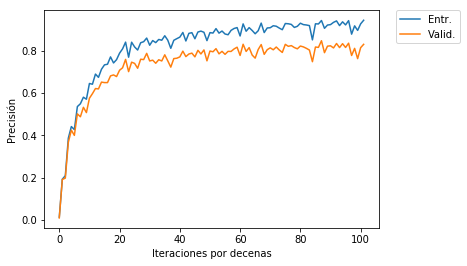

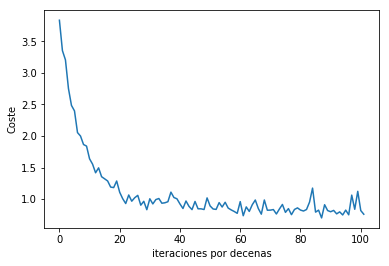

In [31]:
m3_1=Model3_1(300,100,43)
M3_1 = train_minibatch(m3_1, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 5000, imprimir=True)

In [100]:
m3_2=Model3_1(300,100,43)
M3_2 = train_minibatch(m3_2, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 5000, imprimir=False)

4950, Loss: 0.236  Train accuracy: 0.939
4950, Loss: 0.890  Test accuracy: 0.815


In [101]:
m3_3=Model3_1(300,100,43)
M3_3 = train_minibatch(m3_3, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 5000, imprimir=False)

4950, Loss: 0.312  Train accuracy: 0.911
4950, Loss: 0.934  Test accuracy: 0.797


In [102]:
m3_4=Model3_1(300,100,43)
M3_4 = train_minibatch(m3_4, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 5000, imprimir=False)

4950, Loss: 0.293  Train accuracy: 0.919
4950, Loss: 0.919  Test accuracy: 0.798


In [103]:
m3_5=Model3_1(300,100,43)
M3_5 = train_minibatch(m3_5, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 5000, imprimir=False)

4950, Loss: 0.232  Train accuracy: 0.940
4950, Loss: 0.846  Test accuracy: 0.830


In [12]:
m3_6=Model3_1(300,100,43)
M3_6 = train_minibatch(m3_6, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 5000, imprimir=False)

4950, Loss: 0.273  Train accuracy: 0.931
4950, Loss: 0.791  Test accuracy: 0.832


## 3. VISUALIZACIÓN DE PESOS

Echamos un vistazo a los pesos

In [33]:
def normalize(image):
    return (image-image.min())/(image.max()-image.min())

def display_images(images, titles=None, cols=5, interpolation=None):
    """ 
    images: A list of images. It can be either:
        + A list of Numpy arrays. Each array represents an image.
        + A list of lists of numpy arrays. In this casse, the images in the inner
          the inner lists are concatentated to make one image.
    
    """
    
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images)/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(11,11 * height_ratio))
    i=1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize = 9)
        plt.imshow(image, cmap="Greys_r", interpolation=interpolation)
        i += 1

In [34]:
#label_exemplars= [X_train_orig[np.where(Y_train_orig == l)][:][:] for l in range(62)]
label_exemplars =[]
for i in range(43):
    for w in range(len(Y_train_orig)):
        if Y_train_orig[w] == i:
            label_exemplars.append(X_train_orig[w])
            break
#label_counts = [np.count_nonzero(X_train_orig ==l ) for l in range(62)]
label_counts = []
for i in range(43):
    label_counts.append(0)
    for w in range(len(Y_train_orig)):
        if Y_train_orig[w] == i:
            label_counts[i] = label_counts[i]+1

In [37]:
# Print the names of trainable variables.
with m3_1.graph.as_default():
    for v in tf.trainable_variables():
        print(v.name, v.get_shape())

fully_connected/weights:0 (3072, 300)
fully_connected/biases:0 (300,)
fully_connected_1/weights:0 (300, 100)
fully_connected_1/biases:0 (100,)
fully_connected_2/weights:0 (100, 43)
fully_connected_2/biases:0 (43,)


In [38]:
m3_w0 = m3_1.session.run("fully_connected/weights:0")
m3_w1 = m3_1.session.run("fully_connected_1/weights:0")
m3_w2 = m3_1.session.run("fully_connected_2/weights:0")
print("weights0 shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m3_w0.shape, m3_w0.min(), m3_w0.max()))
print("weights1 shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m3_w1.shape, m3_w1.min(), m3_w1.max()))
print("weights2 shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m3_w2.shape, m3_w2.min(), m3_w2.max()))

weights0 shape: (3072, 300)    min: -0.6109    max: 0.6029
weights1 shape: (300, 100)    min: -0.4596    max: 0.4213
weights2 shape: (100, 43)     min: -1.1341    max: 0.5588


In [40]:
def display_weights(weights, limit):
    titles= ["Cat. {}  ({})".format(l,c) for l, c in enumerate(label_counts)]
    images = list(zip(label_exemplars, weights.T.reshape(-1, 32, 32,3)))
    display_images(images[:limit], titles)

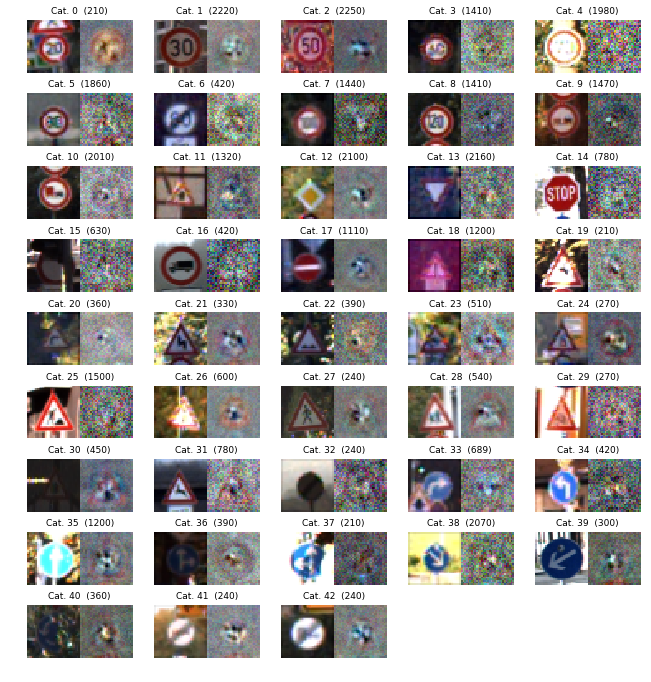

In [43]:
display_weights(m3_w0, 43)

In [87]:
def display_histograms(weights, title):
    cols = 5
    rows = math.ceil(43/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(weights[0]) is not np.ndarray else 1)
    plt.figure(figsize=(15,15* 1))
    for i in range(43):
        plt.subplot(rows,cols,i+1)
        w = weights[:,i]
        plt.title(title[i], fontsize=11)
        plt.tick_params(labelsize=6)
        plt.yticks([])
        plt.xticks([w.min(),w.max()])
        plt.hist(w, bins=43)
    plt.tight_layout()

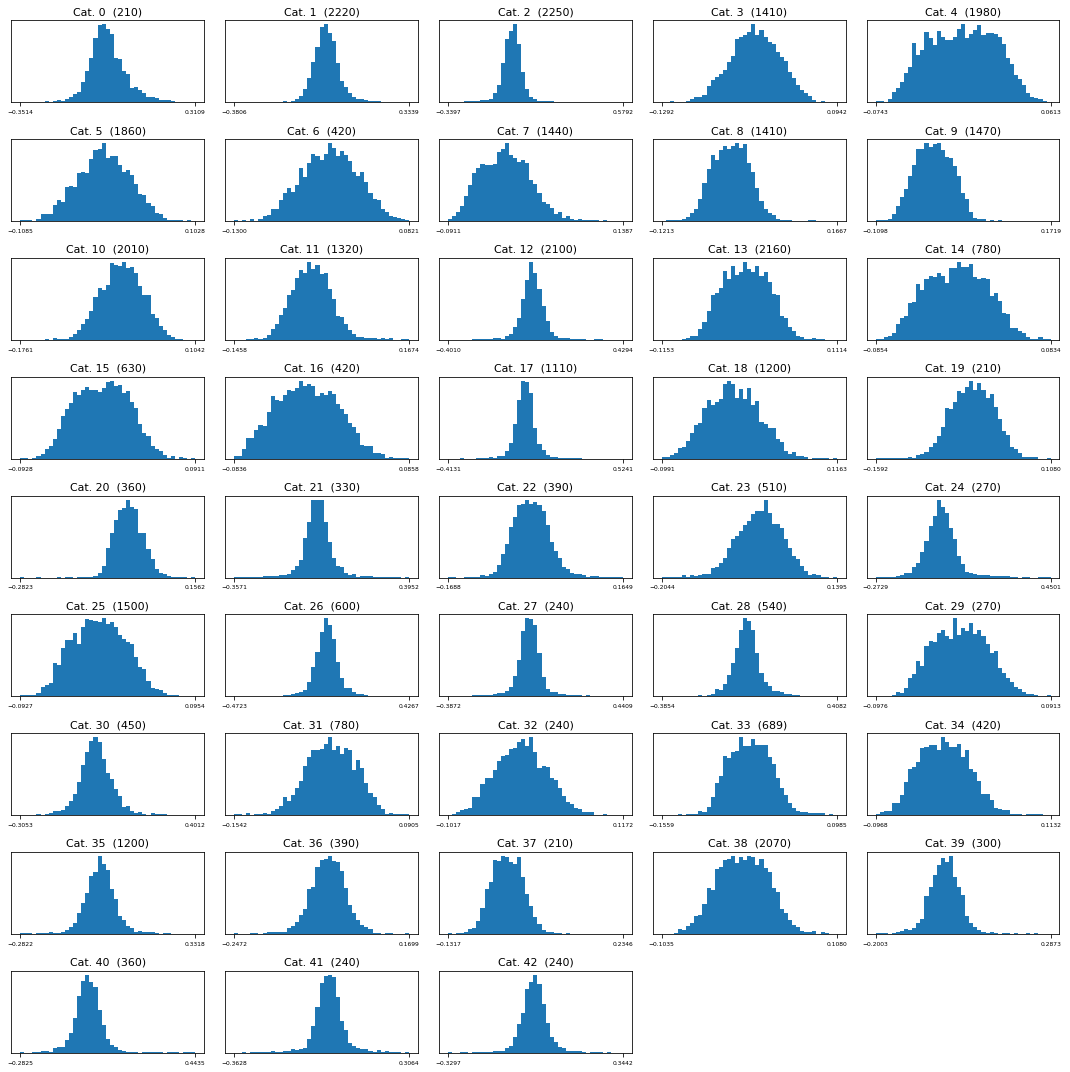

In [88]:
titles= ["Cat. {}  ({})".format(l,c) for l, c in enumerate(label_counts)]
display_histograms(m3_w0, titles)

## 4. CONFUSSION MATRIX

In [89]:
print(__doc__)

#import sklearn
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Automatically created module for IPython interactive environment


In [90]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusión del subconjunto de entrenamiento',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión del subconjunto de entrenamiento")
    else:
        print('Matriz de confusión del subconjunto de entrenamiento')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Matriz de confusión del subconjunto de entrenamiento
[[ 15  35   0 ...   0   0   0]
 [  2 664  21 ...   0   0   0]
 [  0  87 617 ...   0   0   0]
 ...
 [  0   0   0 ...  45   0   0]
 [  0   0   0 ...   0  44   1]
 [  0   0   0 ...   0   1  75]]


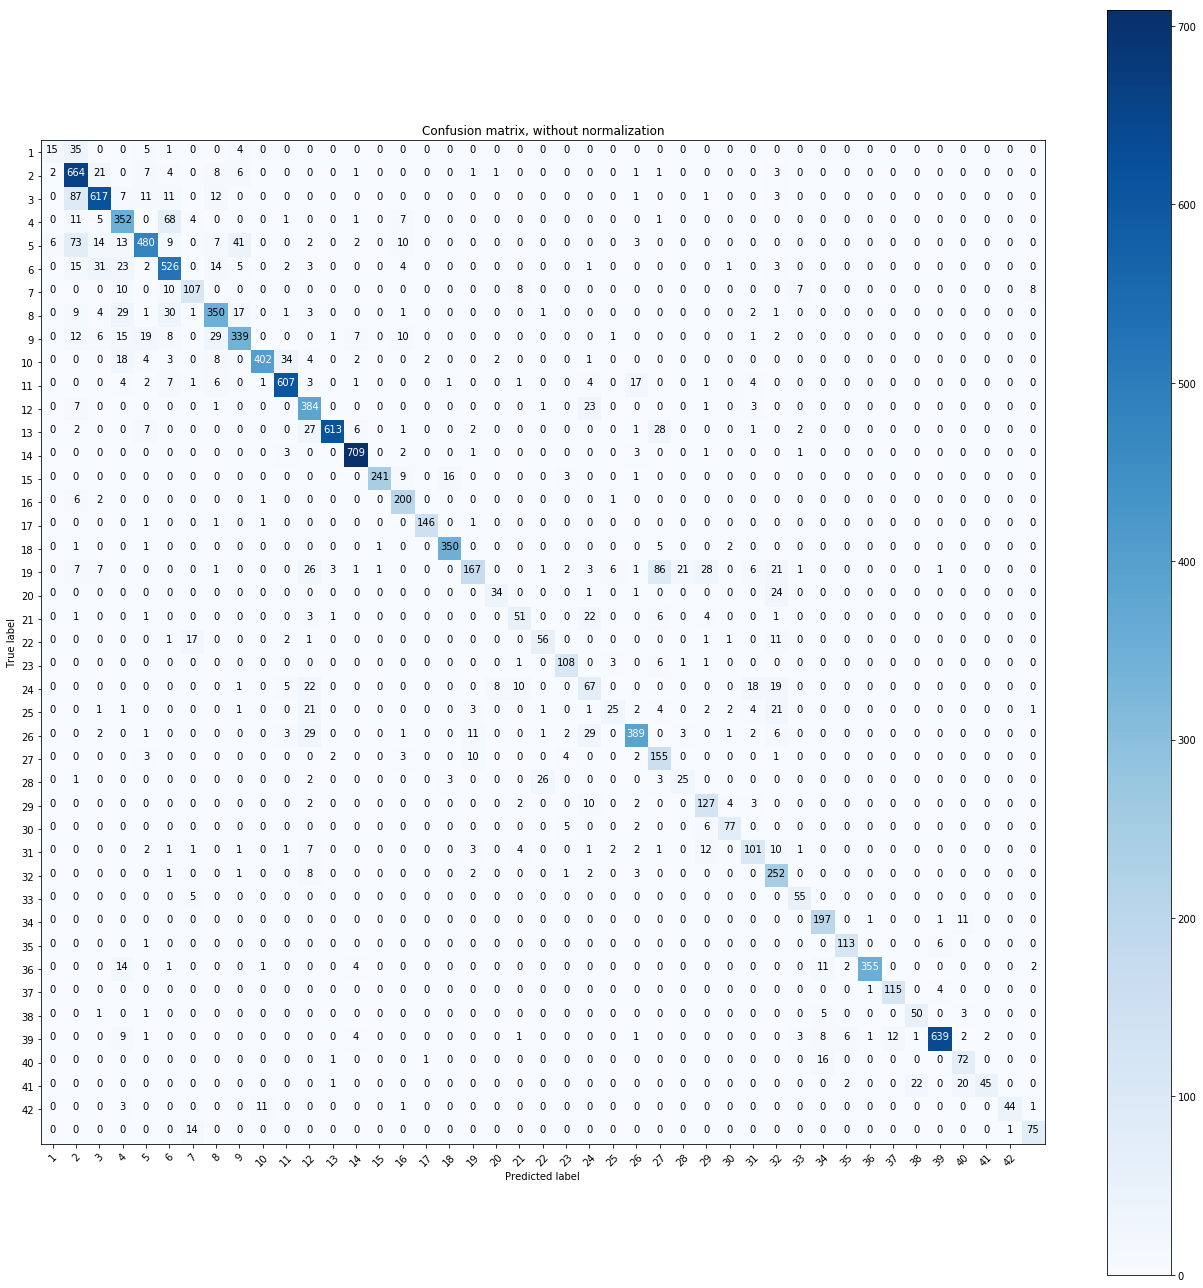

In [93]:
y_pred, _ = m3_1.session.run([m3_1.predicted_labels, m3_1.loss],
                                       {m3_1.images: X_test_orig, m3_1.labels:Y_test_orig})

y_test = Y_test_orig

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names= list(range(1,43))

#Plot non-normalized confusion matrix
plt.figure(figsize=(18,18))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()

## 5. PORCENTAJE DE ACIERTOS

In [94]:
def display_aciertos(images, titles=None, cols=5, interpolation=None):
    """ 
    images: A list of images. It can be either:
        + A list of Numpy arrays. Each array represents an image.
        + A list of lists of numpy arrays. In this casse, the images in the inner
          the inner lists are concatentated to make one image.
    
    """
    
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images)/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(11,11 * height_ratio))
    i=1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize = 10)
        plt.imshow(image, cmap="Greys_r", interpolation=interpolation)
        i += 1

In [95]:
label_exemplars_test =[]
for i in range(43):
    for w in range(len(Y_test_orig)):
        if Y_test_orig[w] == i:
            label_exemplars_test.append(X_test_orig[w])
            break

In [96]:
label_count_test = []
for i in range(43):
    label_count_test.append(0)
    for w in range(len(Y_test_orig)):
        if Y_test_orig[w] == i:
            label_count_test[i] = label_count_test[i]+1

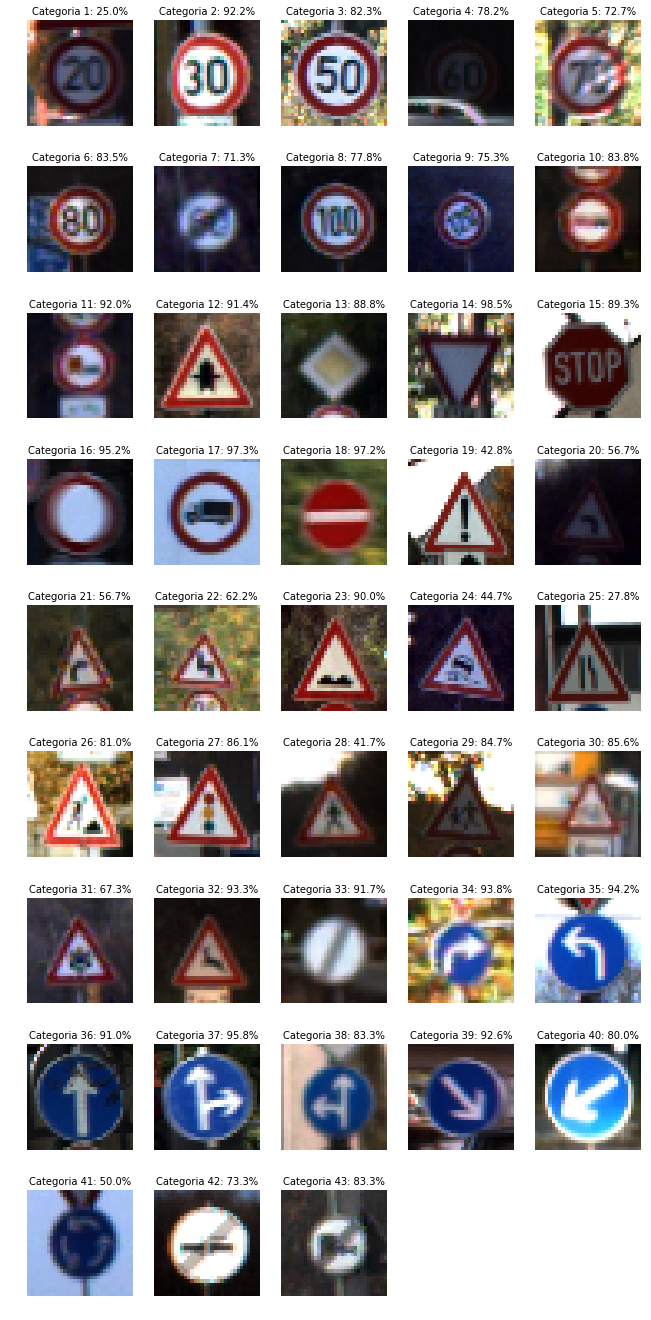

In [97]:
aciertos = [round(cnf_matrix[i,i]/label_count_test[i]*100,1) for i in range(43)]
aciertos = [str(round(cnf_matrix[i,i]/label_count_test[i]*100,1)) for i in range(43)]
titles = [("Categoria "+str(i+1)+": "+aciertos[i]+"%") for i in range(43)]
display_aciertos(label_exemplars_test, titles)